# Data Exploration
Data exploration is the process of examining and visualizing your data before modeling. It helps you understand the structure, patterns, distributions, and potential issues (like missing values or outliers) in your dataset. This step guides data cleaning, feature engineering, and model selection by revealing important insights about the data.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

In [2]:
version_tag = "dev"

## Load Data

In [3]:
input_folder = "../.local/analysis_pipeline/data_etl"
model_data = pd.read_parquet(f"{input_folder}/model_data_{version_tag}.parquet")
print( model_data.shape )
model_data.head(5)

(22619, 24)


,id,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,...,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,clm,numclaims,claimcst0,veh_cnt,data_segment
0,1,0.77,0.444504,SEDAN,4,M,D,3,petrol,147,...,weekday,6pm - 12am,6,640.448137,1.0,0,0,0.0,1,1|model
1,2,4.45,0.562183,STNWG,1,M,A,3,petrol,158,...,weekday,6am - 12pm,12,683.749691,0.0,0,0,0.0,1,1|model
2,3,4.90,0.465244,STNWG,1,F,A,3,petrol,159,...,weekday,6pm - 12am,6,653.656117,1.0,0,0,0.0,1,1|model
3,4,0.48,0.271039,PANVN,4,M,A,4,petrol,80,...,weekday,12pm - 6pm,12,642.574671,0.0,0,0,0.0,1,1|model
4,5,0.85,0.141624,SEDAN,4,F,A,5,petrol,126,...,weekday,6am - 12pm,6,647.175035,0.0,0,0,0.0,1,1|model


In [4]:
inference_data = pd.read_parquet(f"{input_folder}/inference_data_{version_tag}.parquet")
print( inference_data.shape )
inference_data.head(5)

(22620, 21)


,id,veh_value,exposure,veh_body,veh_age,gender,area,agecat,engine_type,max_power,...,veh_color,marital_status,e_bill,time_of_week_driven,time_driven,trm_len,credit_score,high_education_ind,veh_cnt,data_segment
0,1,3.40,0.076279,STNWG,2,M,B,4,petrol,174,...,black,S,1,weekday,6pm - 12am,6,648.247594,0,1,2|inference
1,2,2.55,0.093443,STNWG,2,F,A,3,petrol,181,...,yellow,M,0,weekday,12am - 6 am,12,637.752677,0,1,2|inference
2,3,3.04,0.157762,STNWG,2,F,E,4,petrol,136,...,white,S,1,weekday,12pm - 6pm,12,661.483786,0,1,2|inference
3,4,2.05,0.560735,MIBUS,4,M,C,6,dissel,164,...,gray,M,1,weekday,6am - 12pm,12,647.846365,0,1,2|inference
4,5,1.93,0.258275,HBACK,2,M,C,4,dissel,89,...,black,S,0,weekday,6am - 12pm,12,640.257550,0,1,2|inference


## Target Variable Analysis
### Create target variable

In [5]:
# Rename columns for clarity and consistency
model_data = model_data.rename(columns={'numclaims': 'claim_cnt'})
model_data = model_data.rename(columns={'claimcst0': 'claim_amt'})

# Create a new column 'claim_sev' (claim severity) as claim_amt divided by claim_cnt
# If claim_cnt is zero, set claim_sev to NaN to avoid division by zero
model_data['claim_sev'] = model_data.apply(
    lambda row: row['claim_amt'] / row['claim_cnt'] if row['claim_cnt'] != 0 else np.nan,
    axis=1
)

### Visualize target variables
#### Visualize claim count/frequency variable

Mean of claim_cnt: 0.073
Variance of claim_cnt: 0.078


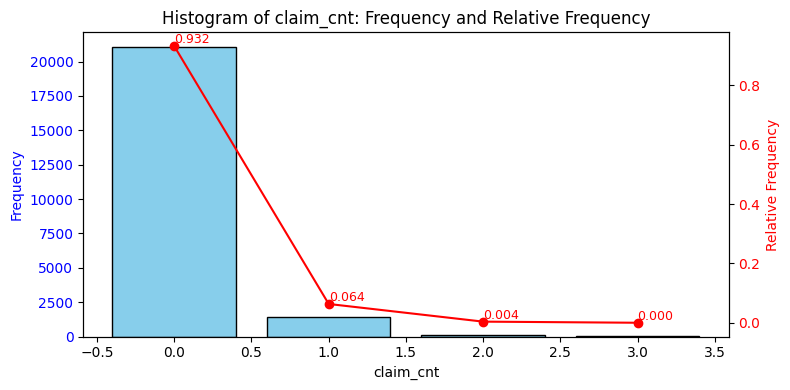

In [6]:
# Plot a histogram of 'claim_cnt' showing both frequency and relative frequency, with annotations
import matplotlib.pyplot as plt
import numpy as np

# Print the mean and variance of the claim_cnt column
mean_claim_cnt = model_data['claim_cnt'].mean()
var_claim_cnt = model_data['claim_cnt'].var()
print(f"Mean of claim_cnt: {mean_claim_cnt:.3f}")
print(f"Variance of claim_cnt: {var_claim_cnt:.3f}")

# Show the claim count distribution
counts, bins = np.histogram(model_data['claim_cnt'], bins=range(int(model_data['claim_cnt'].min()), int(model_data['claim_cnt'].max())+2))
rel_freq = counts / counts.sum()

fig, ax1 = plt.subplots(figsize=(8,4))

# Frequency histogram
ax1.bar(bins[:-1], counts, width=0.8, color='skyblue', edgecolor='black', label='Frequency')
ax1.set_xlabel('claim_cnt')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Relative frequency (secondary axis)
ax2 = ax1.twinx()
ax2.plot(bins[:-1], rel_freq, 'o-', color='red', label='Relative Frequency')
ax2.set_ylabel('Relative Frequency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Annotate relative frequency values next to red dots
for x, y in zip(bins[:-1], rel_freq):
    ax2.text(x, y, f'{y:.3f}', color='red', fontsize=9, ha='left', va='bottom')

plt.title('Histogram of claim_cnt: Frequency and Relative Frequency')
fig.tight_layout()
plt.show()

#### Visualize claim severity

Gamma Distribution: Kurtosis and Mean-Variance Relationship
- **Kurtosis**: The excess kurtosis of a Gamma distribution with shape parameter $k$ is $6/k$. The total kurtosis is $6/k + 3$.
- **Mean and Variance**: For shape $k$ and scale $\theta$:
    - Mean: $\mu = k\theta$
    - Variance: $\sigma^2 = k\theta^2$
    - So, $\text{Variance} = \text{Mean} \times \theta$

Mean of claim_sev: 2263.458
Variance of claim_sev: 17414700.324
Skewness of claim_sev: 5.561
Kurtosis of claim_sev: 49.822


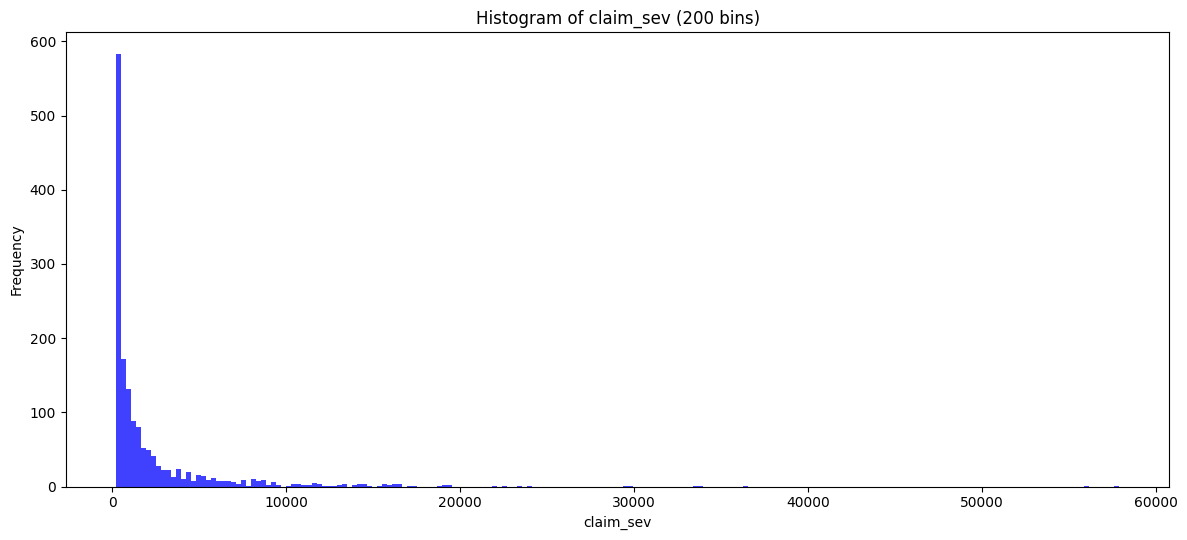

In [7]:
# Compute mean, variance, skewness, and kurtosis of claim_sev
mean_sev = model_data['claim_sev'].dropna().mean()
var_sev = model_data['claim_sev'].dropna().var()
skew_sev = model_data['claim_sev'].dropna().skew()
kurt_sev = model_data['claim_sev'].dropna().kurtosis()
print(f"Mean of claim_sev: {mean_sev:.3f}")
print(f"Variance of claim_sev: {var_sev:.3f}")
print(f"Skewness of claim_sev: {skew_sev:.3f}")
print(f"Kurtosis of claim_sev: {kurt_sev:.3f}")

# Plot a histogram of 'claim_sev' with 100 bins
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5.5))
plt.hist(model_data['claim_sev'].dropna(), bins=200, facecolor='blue', alpha=0.75)
plt.xlabel('claim_sev')
plt.ylabel('Frequency')
plt.title('Histogram of claim_sev (200 bins)')
plt.tight_layout()
plt.show()

Cap severity variable

Kurtosis of original claim_sev: 49.657
Kurtosis of capped claim_sev: 12.729
After capping at the 99.5 percentile (cap value: 24000.0), the % of total capped claim_sev to the total original claim_sev is 96.9%.


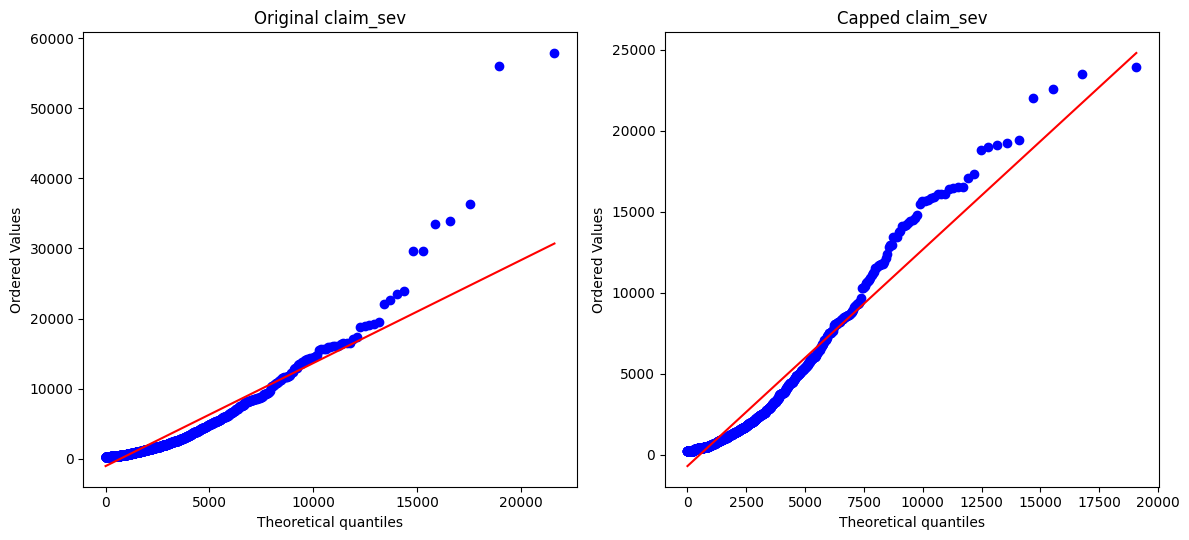

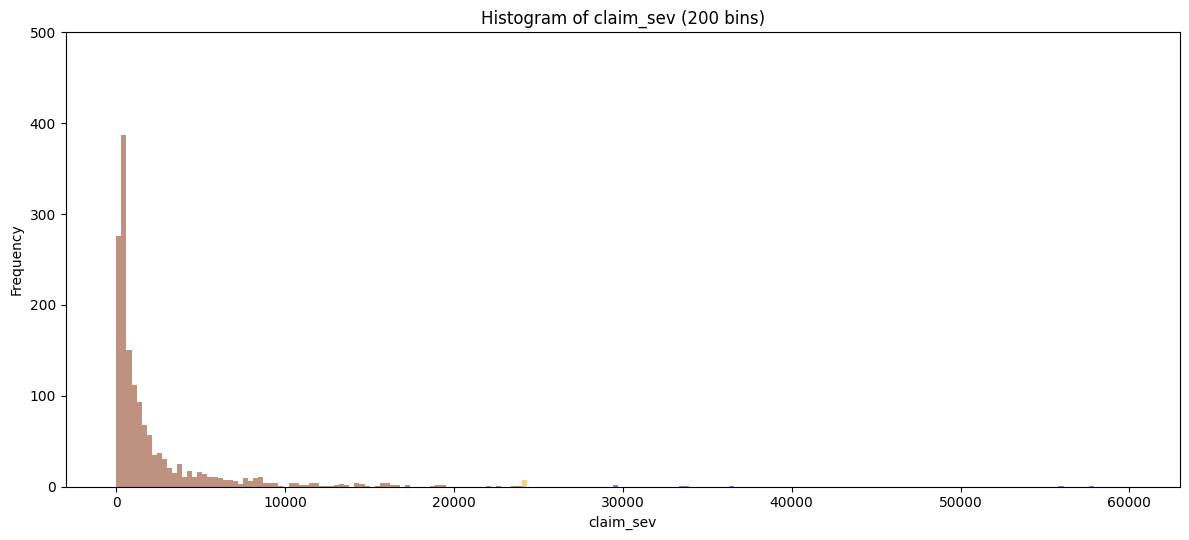

In [8]:
# QQ plot for claim_sev before and after capping at a specified percentile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.pylab import rcParams

# Set capping percentile and calculate cap value
cap_percentile = 99.5
cap_value = 1000 * round(np.nanpercentile(model_data['claim_sev'], cap_percentile) / 1000, 0)

# Cap the claim_sev variable
model_data['claim_sev_capped'] = model_data['claim_sev'].clip(upper=cap_value)

# Calculate share of capped to original
share_incurred = model_data['claim_sev_capped'].sum() / model_data['claim_sev'].sum()

# Print kurtosis and share information
print(f"Kurtosis of original claim_sev: {stats.kurtosis(model_data['claim_sev'].dropna()):.3f}")
print(f"Kurtosis of capped claim_sev: {stats.kurtosis(model_data['claim_sev_capped'].dropna()):.3f}")
print(f"After capping at the {cap_percentile} percentile (cap value: {cap_value}), the % of total capped claim_sev to the total original claim_sev is {100 * share_incurred:.1f}%.")

# Prepare data for QQ plots
y_ori = model_data['claim_sev'].dropna()
y_capped = model_data.loc[model_data['claim_sev']<=cap_value, 'claim_sev_capped'].dropna()

# Fit gamma distributions
sparams_ori = stats.gamma.fit(y_ori, floc=0)
sparams_capped = stats.gamma.fit(y_capped, floc=0)

# Plot QQ plots
rcParams['figure.figsize'] = 12, 5.5
fig, (ax1, ax2) = plt.subplots(1, 2)
stats.probplot(y_ori, sparams_ori, dist='gamma', plot=ax1)
ax1.set_title('Original claim_sev')
stats.probplot(y_capped, sparams_capped, dist='gamma', plot=ax2)
ax2.set_title('Capped claim_sev')
plt.tight_layout()
plt.show()

# Plot a histogram of 'claim_sev' and 'claim_sev_capped' with 200 bins
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 12, 5.5
plt.hist(model_data['claim_sev'].dropna(), bins=200, range=[0, 60000], facecolor='blue', alpha=0.5, label='Original')
plt.hist(model_data['claim_sev_capped'].dropna(), bins=200, range=[0, 60000], facecolor='orange', alpha=0.5, label='Capped')
plt.xlabel('claim_sev')
plt.ylabel('Frequency')
plt.ylim([0,500])
plt.title('Histogram of claim_sev (200 bins)')
plt.tight_layout()
plt.show()

#### Compute total claim amount

In [9]:
# Compute the capped claim amount
model_data['claim_amt_capped'] = model_data.apply(
    lambda row: row['claim_cnt'] * row['claim_sev_capped'] if row['claim_cnt']!=0 else 0, 
    axis=1
)

# Print the total original and capped claim amounts
print(f"Average original claim amount: {model_data['claim_amt'].mean():.3f}")
print(f"Average capped claim amount: {model_data['claim_amt_capped'].mean():.3f}")
# Print the combined original and capped loss ratios - per exposure
print(f"Combined original loss - exposure ratio: {model_data['claim_amt'].sum() / model_data['exposure'].sum():.3f}")
print(f"Combined capped loss - exposure ratio: {model_data['claim_amt_capped'].sum() / model_data['exposure'].sum():.3f}")

Average original claim amount: 163.048
Average capped claim amount: 158.237
Combined original loss - exposure ratio: 376.521
Combined capped loss - exposure ratio: 365.412


## Split Data

In [10]:
# Add a 'fold' column with random assignment of 1,2,3,4 to each row, using a fixed random seed
np.random.seed(42)  # Fix the random seed for reproducibility
model_data['fold'] = np.random.choice([1, 2, 3, 4], size=len(model_data))
rich.print(model_data['fold'].value_counts())

# Create a 'sample' column based on the 'fold' column
model_data['sample'] = np.where(model_data['fold'].isin([1,2,3]), '1|bld', '2|val')
rich.print(model_data['sample'].value_counts())

fold
1    5716
4    5662
2    5661
3    5580
Name: count, dtype: int64

sample
1|bld    16957
2|val     5662
Name: count, dtype: int64

### Load Data Into Memory

In [11]:
output_folder = "../.local/analysis_pipeline/data_exploration"
os.makedirs(output_folder, exist_ok=True)
model_data.to_parquet(f"{output_folder}/model_data_{version_tag}.parquet", index=False)
inference_data.to_parquet(f"{output_folder}/inference_data_{version_tag}.parquet", index=False)

## Consistency Check
### Create a combined data set for consistency check purpose

In [12]:
# Create predictor list
veh_pred_lst = ['veh_value', 'veh_body', 'veh_age', 'engine_type', 'max_power', 'veh_color', ]
policy_pred_lst = ['gender', 'agecat', 'e_bill' ]
driving_behavior_pred_lst = ['area', 'time_of_week_driven', 'time_driven']
demo_pred_lst = ['marital_status', 'high_education_ind', 'credit_score', 'driving_history_score']
pred_lst = veh_pred_lst + policy_pred_lst + driving_behavior_pred_lst + demo_pred_lst
cols = ['data_segment', 'exposure'] + pred_lst

# Concatenate model_data[cols] and inference_data[cols] vertically
combined_expo_pred_data = pd.concat(
    [model_data[cols], 
     inference_data[cols]], 
     axis=0, 
     ignore_index=True
     )
print('Combined data shape:', combined_expo_pred_data.shape)
combined_expo_pred_data.head()

Combined data shape: (45239, 18)


,data_segment,exposure,veh_value,veh_body,veh_age,engine_type,max_power,veh_color,gender,agecat,e_bill,area,time_of_week_driven,time_driven,marital_status,high_education_ind,credit_score,driving_history_score
0,1|model,0.444504,0.77,SEDAN,4,petrol,147,black,M,3,1,D,weekday,6pm - 12am,S,1.0,640.448137,67.0
1,1|model,0.562183,4.45,STNWG,1,petrol,158,white,M,3,1,A,weekday,6am - 12pm,S,0.0,683.749691,76.0
2,1|model,0.465244,4.90,STNWG,1,petrol,159,black,F,3,1,A,weekday,6pm - 12am,M,1.0,653.656117,58.0
3,1|model,0.271039,0.48,PANVN,4,petrol,80,white,M,4,1,A,weekday,12pm - 6pm,S,0.0,642.574671,72.0
4,1|model,0.141624,0.85,SEDAN,4,petrol,126,white,F,5,0,A,weekday,6am - 12pm,S,0.0,647.175035,91.0



--- Consistency Plot for veh_value ---


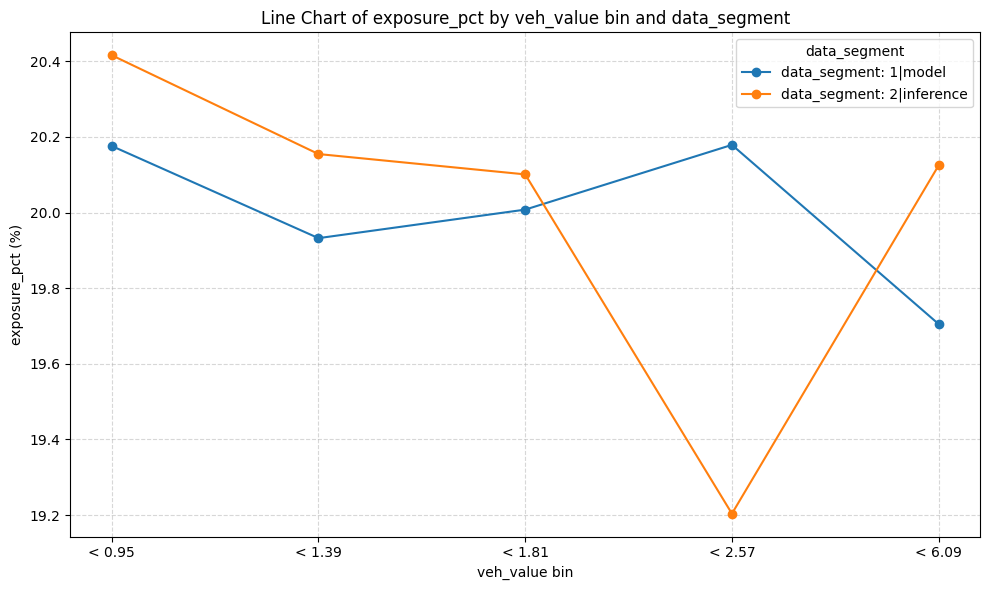


--- Consistency Plot for veh_body ---


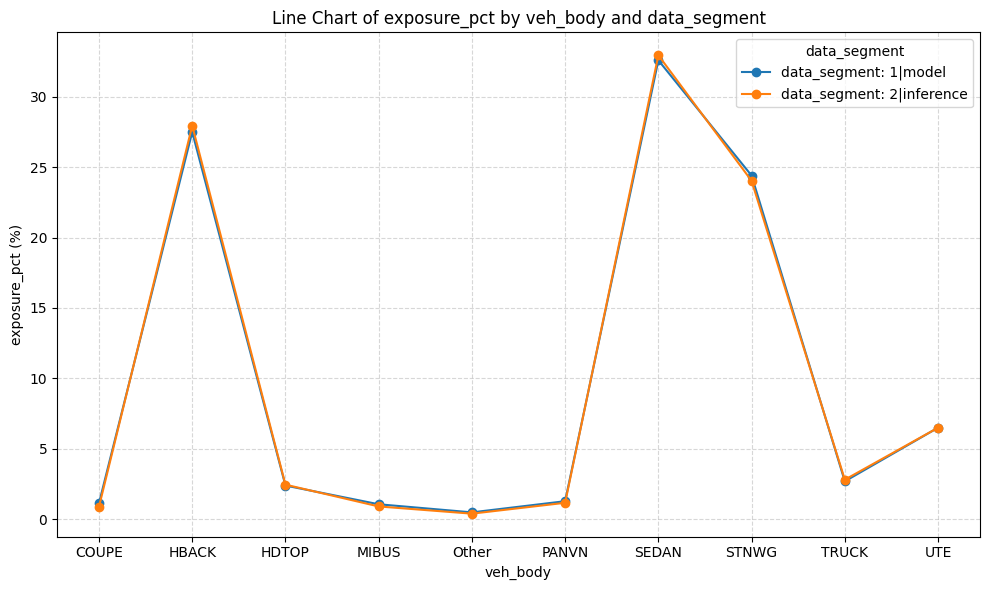


--- Consistency Plot for veh_age ---


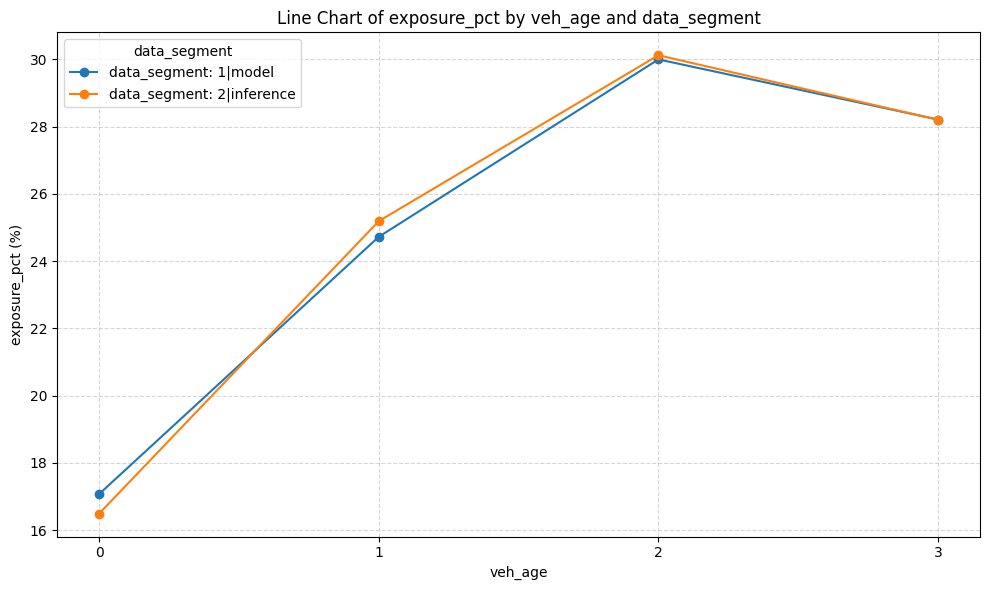


--- Consistency Plot for engine_type ---


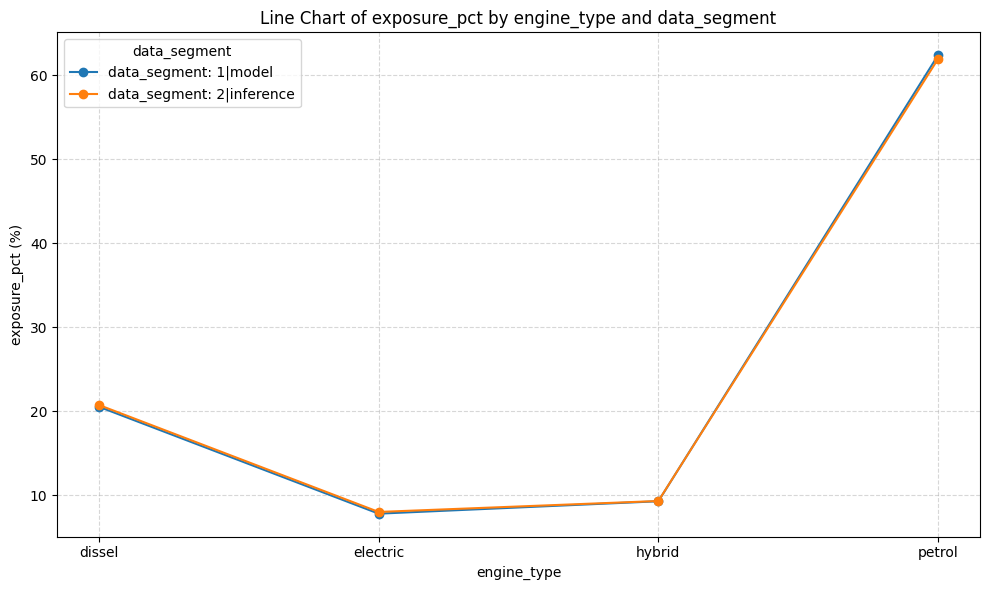


--- Consistency Plot for max_power ---


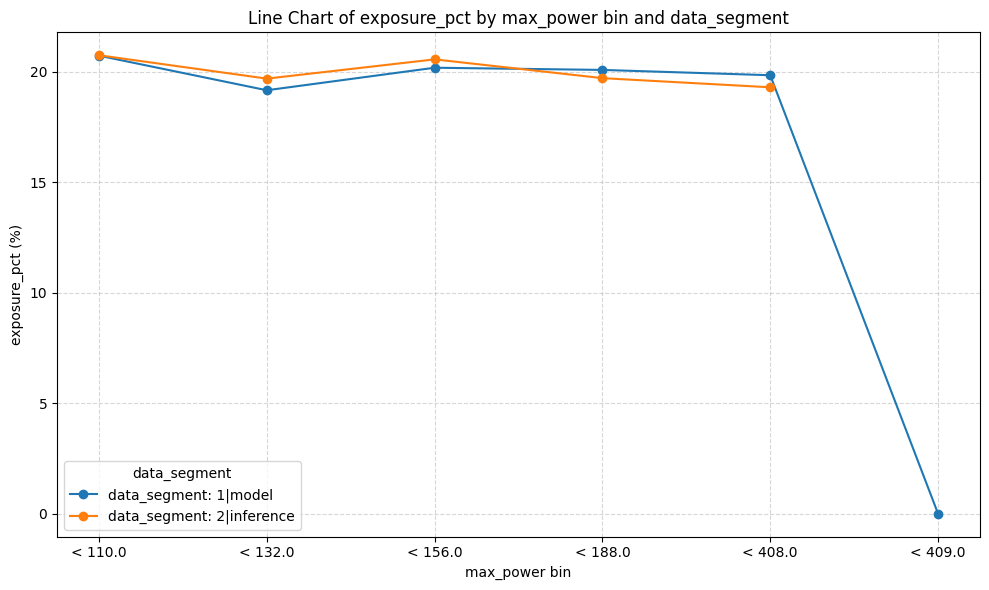


--- Consistency Plot for veh_color ---


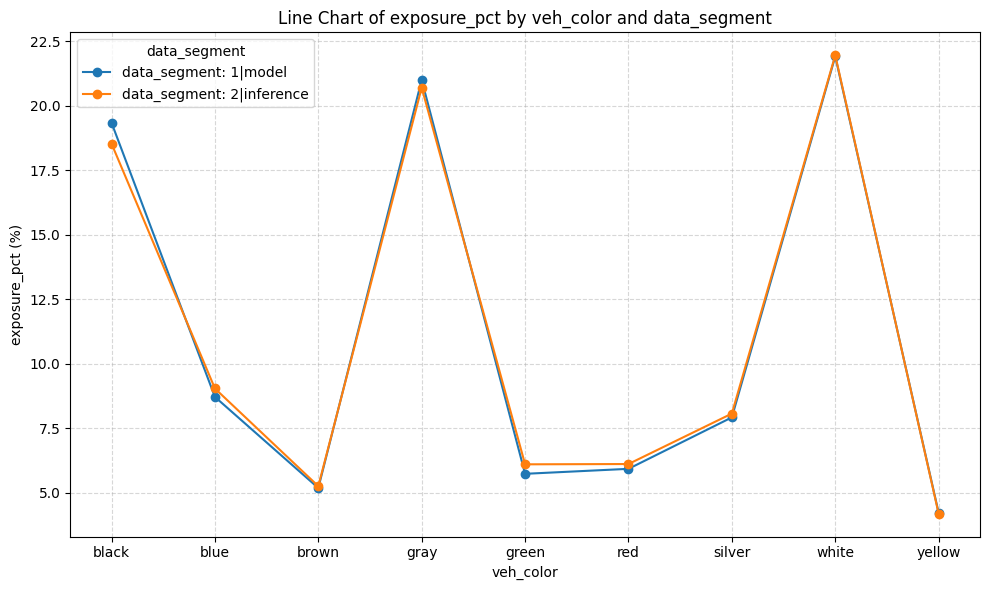


--- Consistency Plot for gender ---


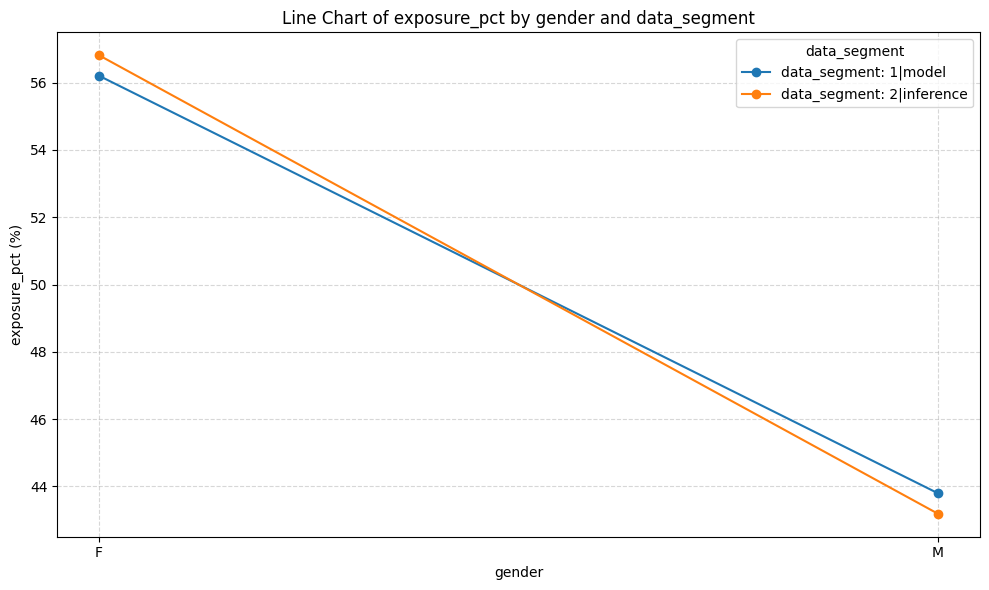


--- Consistency Plot for agecat ---


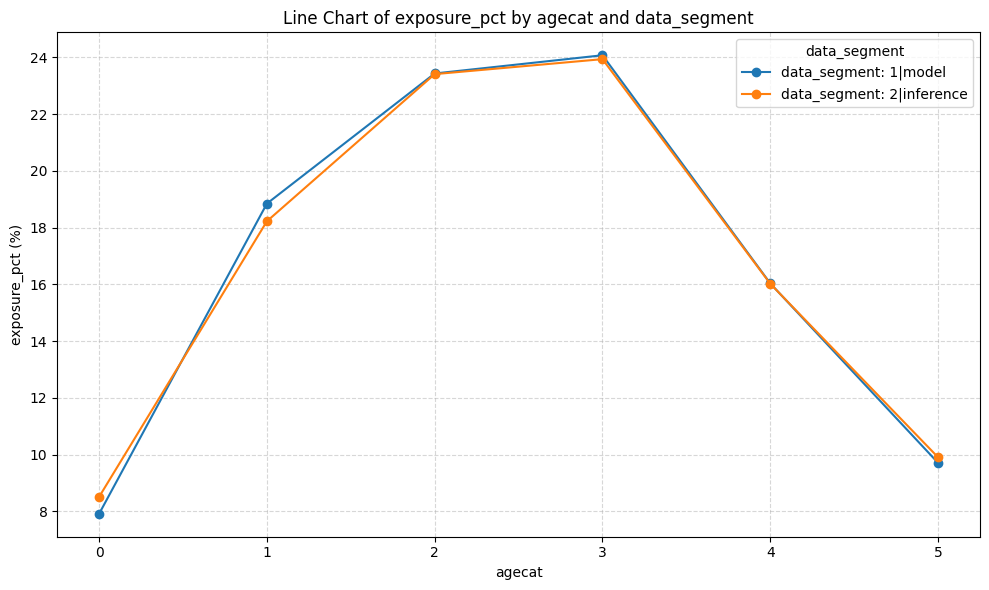


--- Consistency Plot for e_bill ---


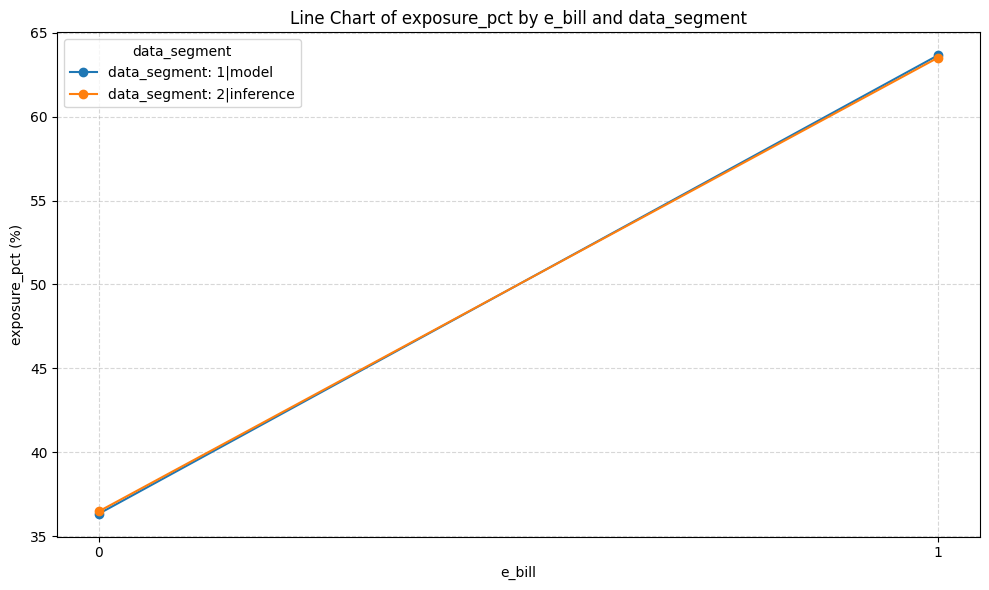


--- Consistency Plot for area ---


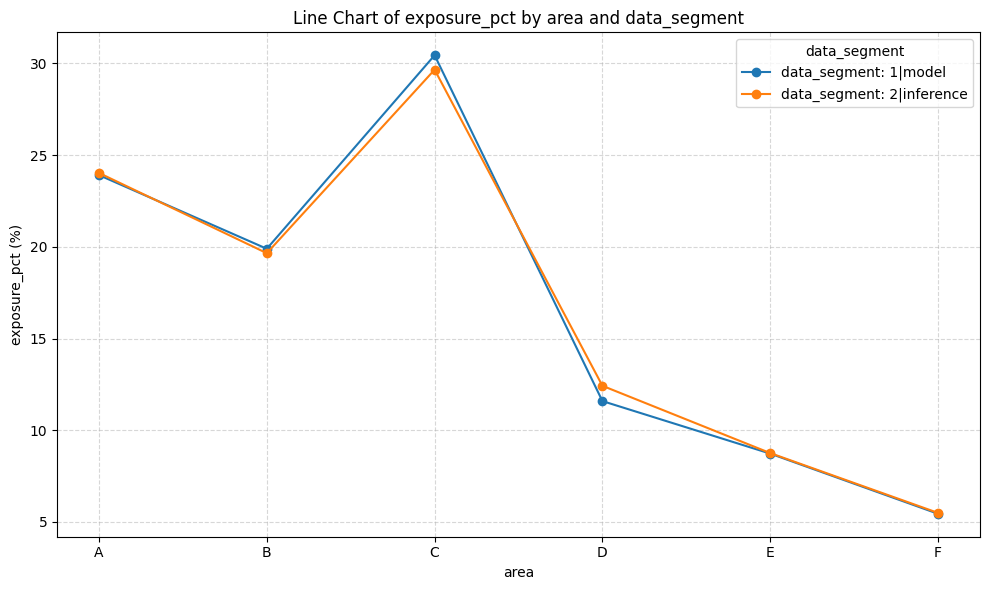


--- Consistency Plot for time_of_week_driven ---


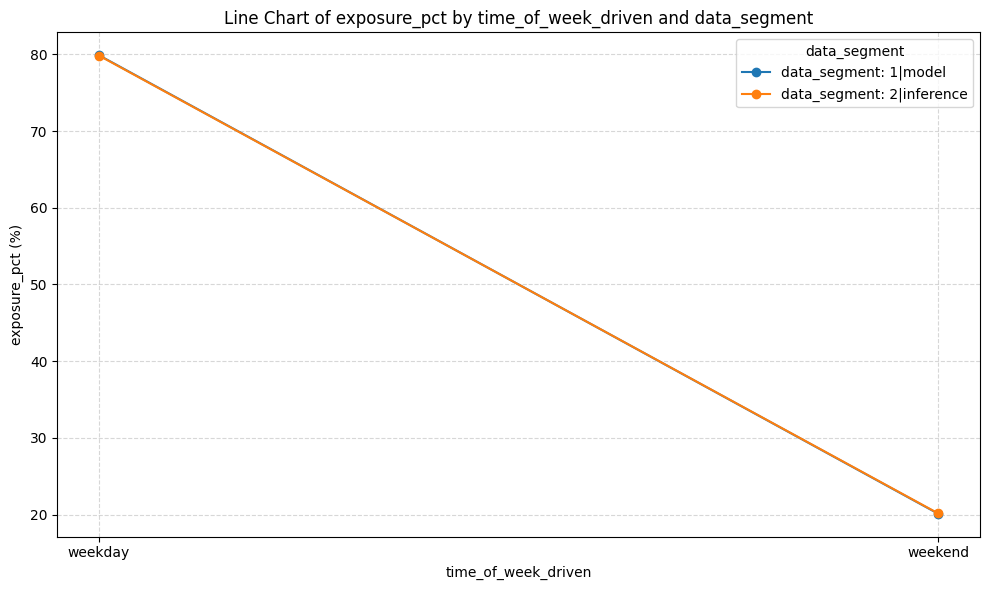


--- Consistency Plot for time_driven ---


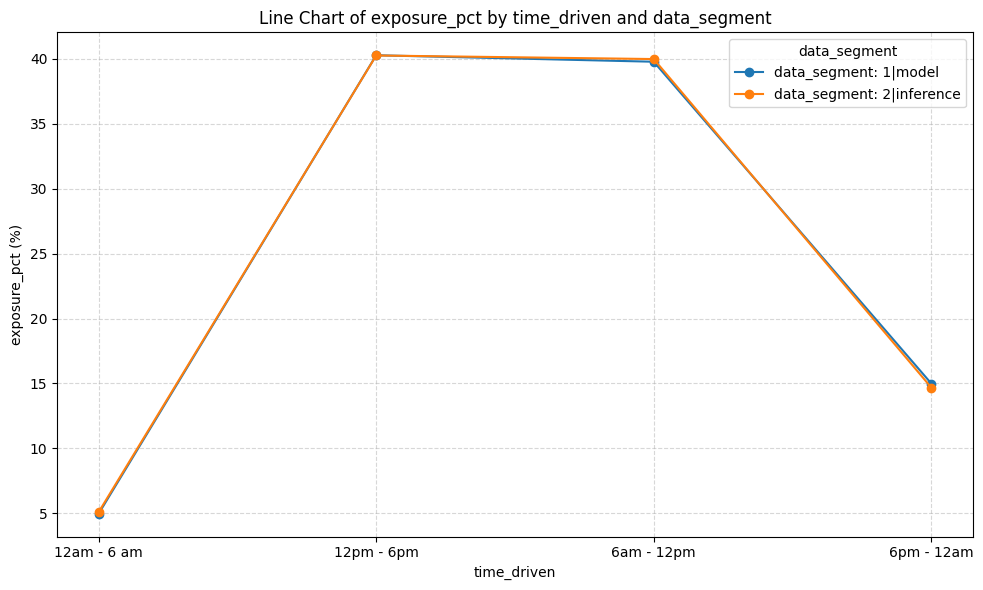


--- Consistency Plot for marital_status ---


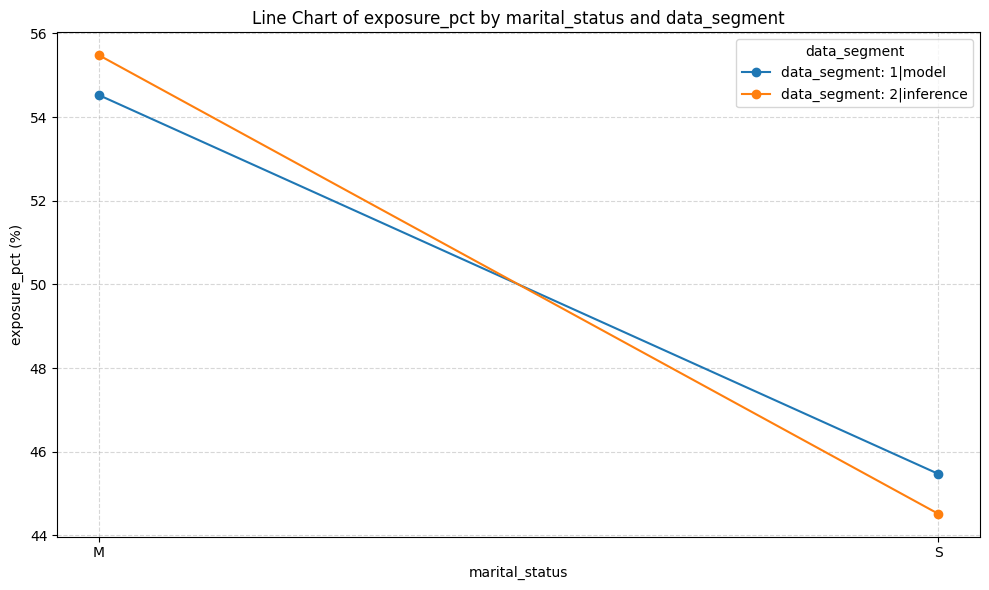


--- Consistency Plot for high_education_ind ---


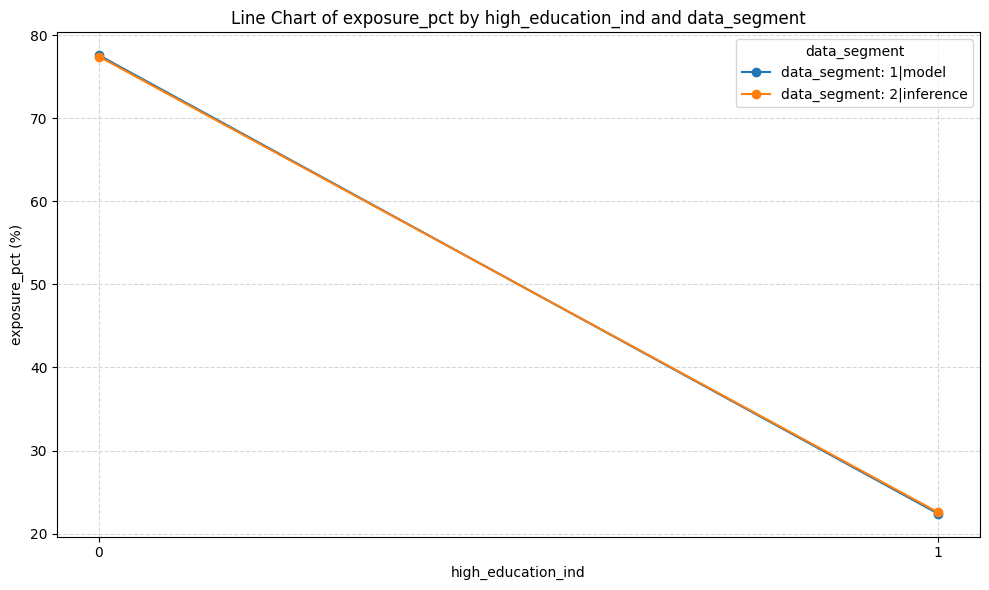


--- Consistency Plot for credit_score ---


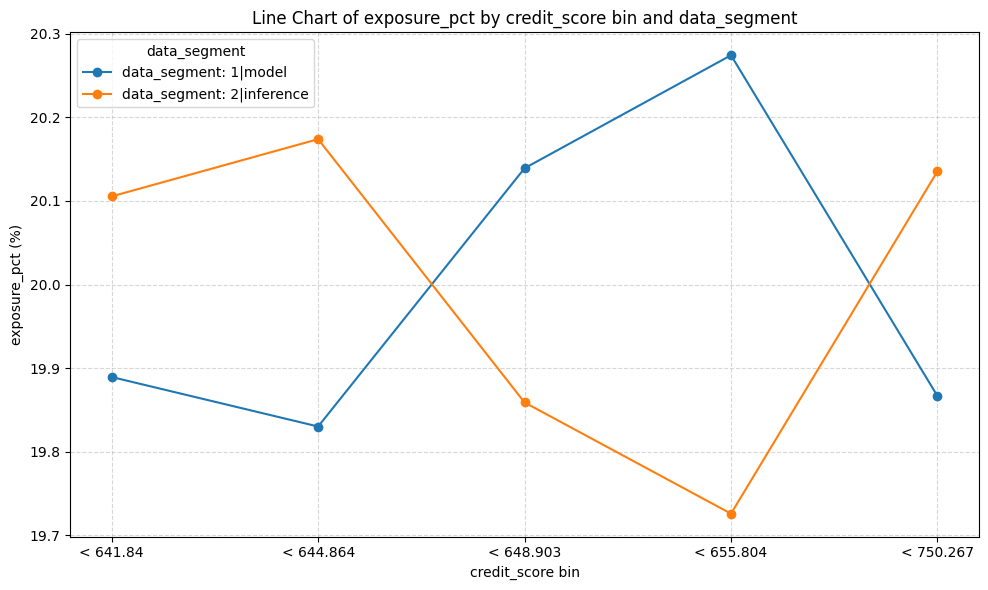


--- Consistency Plot for driving_history_score ---


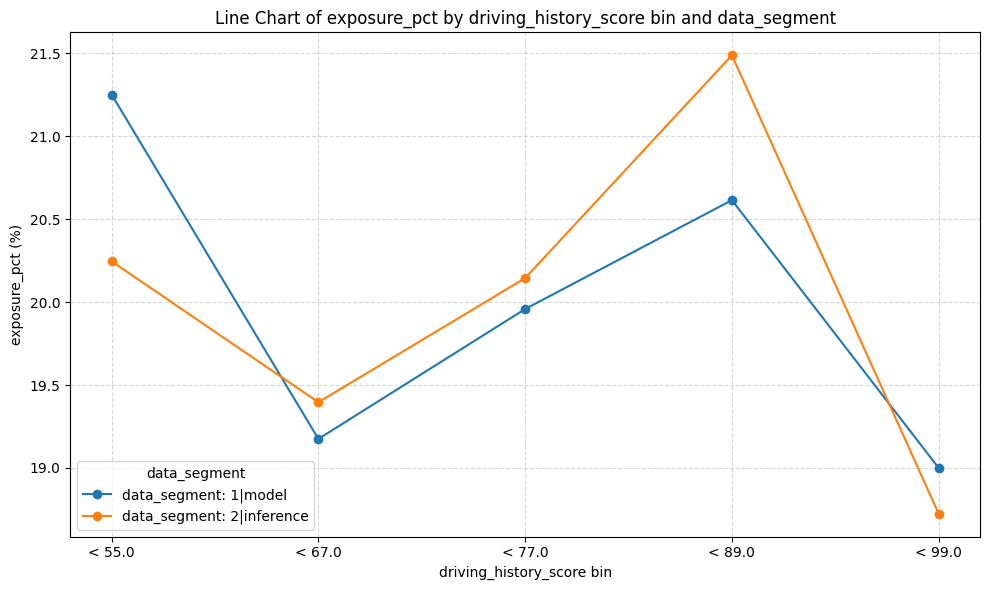

In [13]:
import sys
sys.path.append(os.path.abspath(".."))
from analysis_tool_chest.data_exploration import ConsistencyCheckList

ccl = ConsistencyCheckList(
    data=combined_expo_pred_data, 
    pred_var_lst=pred_lst, 
    expo_var='exposure', 
    year_var='data_segment')
ccl.run_all()
ccl.plot_all()

### Consistency check illustration with multiple years of data
<div style="background-color: #f8f8f8; padding: 10px;">
    <img src="../images/2_stability_chart.png" alt="Transformation Illustration" style="max-width:50%;">
</div>

## Predictiveness Check


--- Predictiveness Plot for veh_value ---


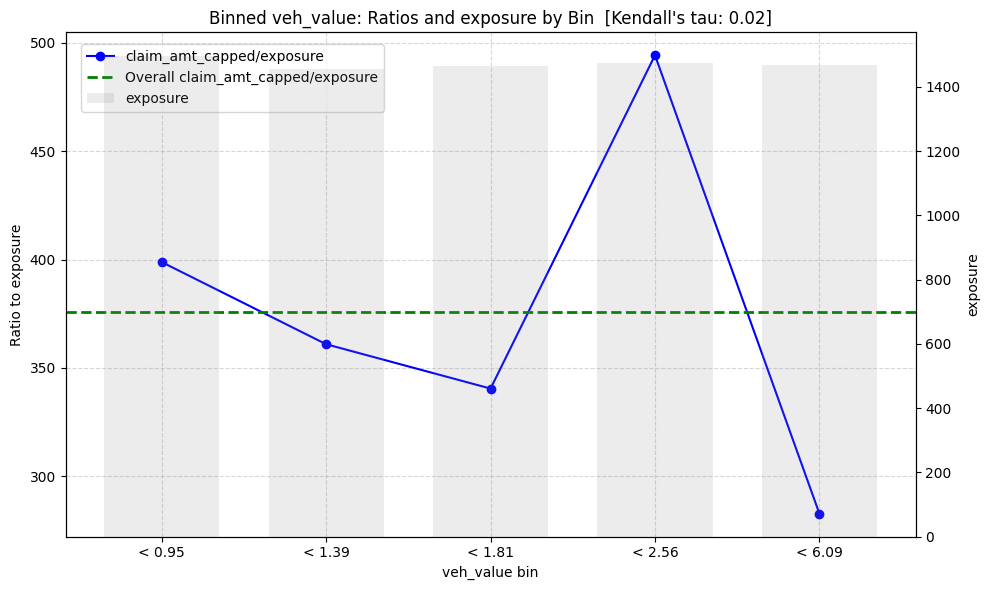


--- Predictiveness Plot for veh_body ---


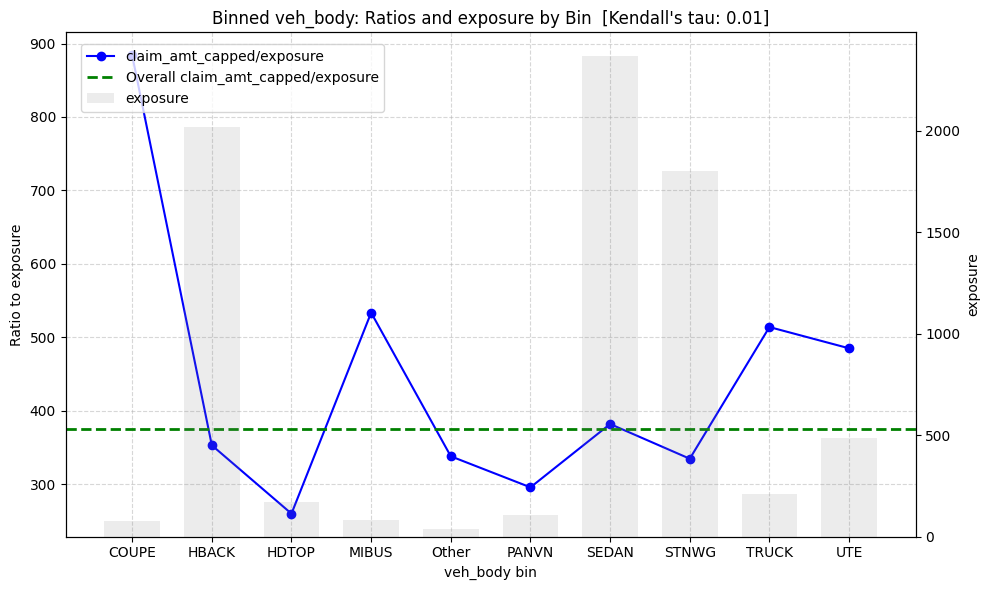


--- Predictiveness Plot for veh_age ---


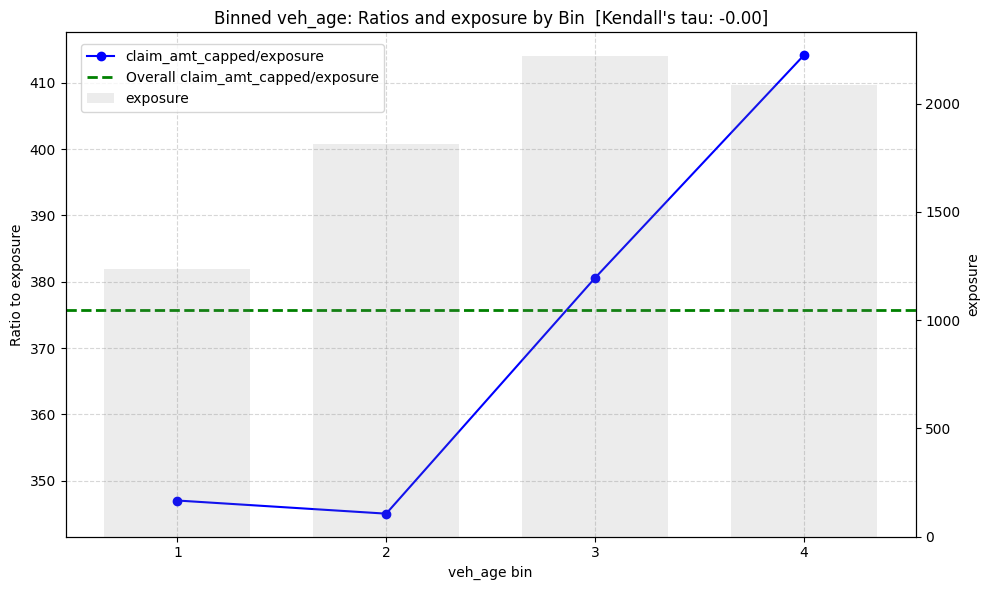


--- Predictiveness Plot for engine_type ---


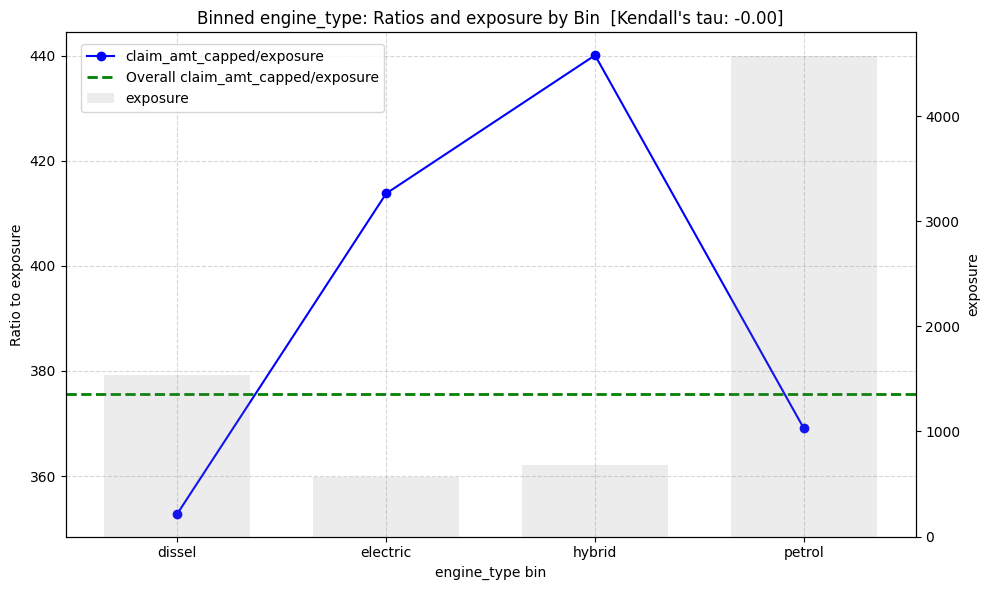


--- Predictiveness Plot for max_power ---


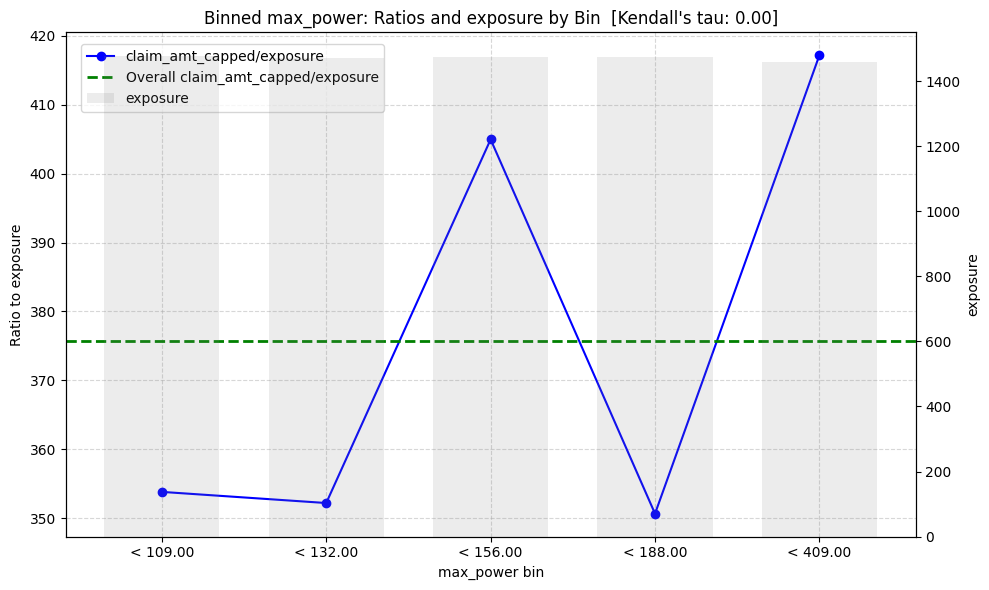


--- Predictiveness Plot for veh_color ---


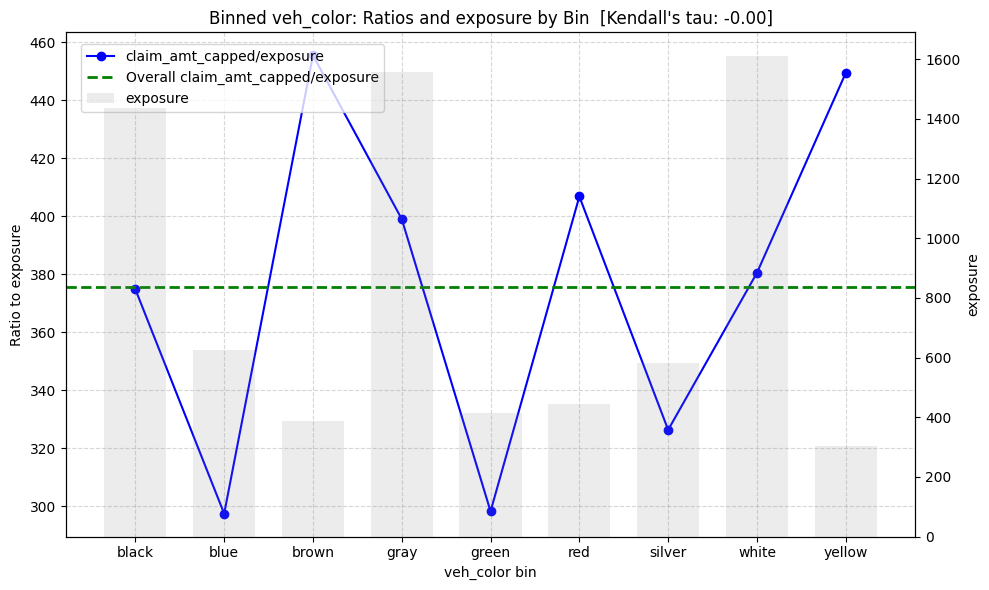


--- Predictiveness Plot for gender ---


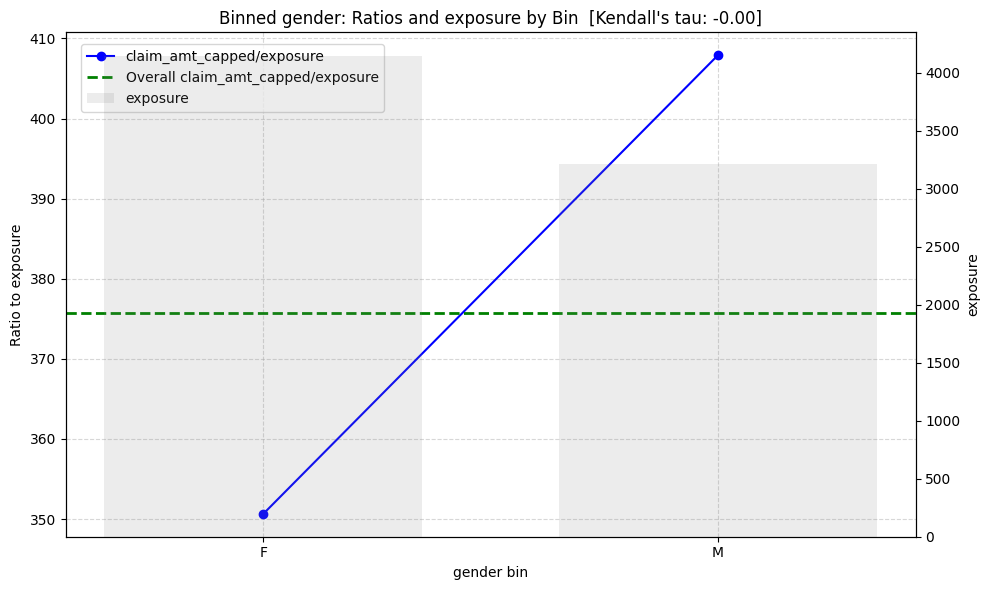


--- Predictiveness Plot for agecat ---


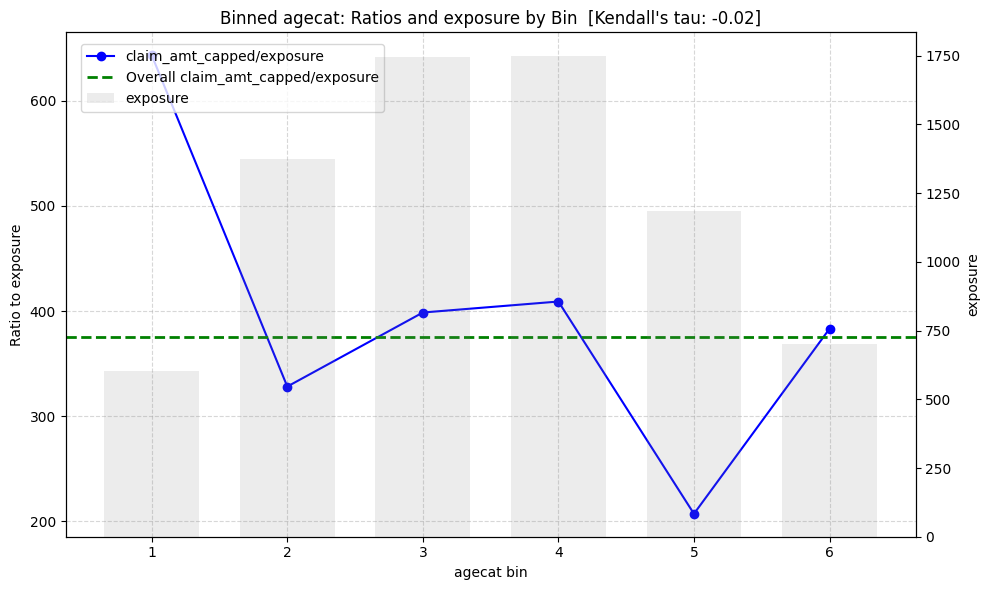


--- Predictiveness Plot for e_bill ---


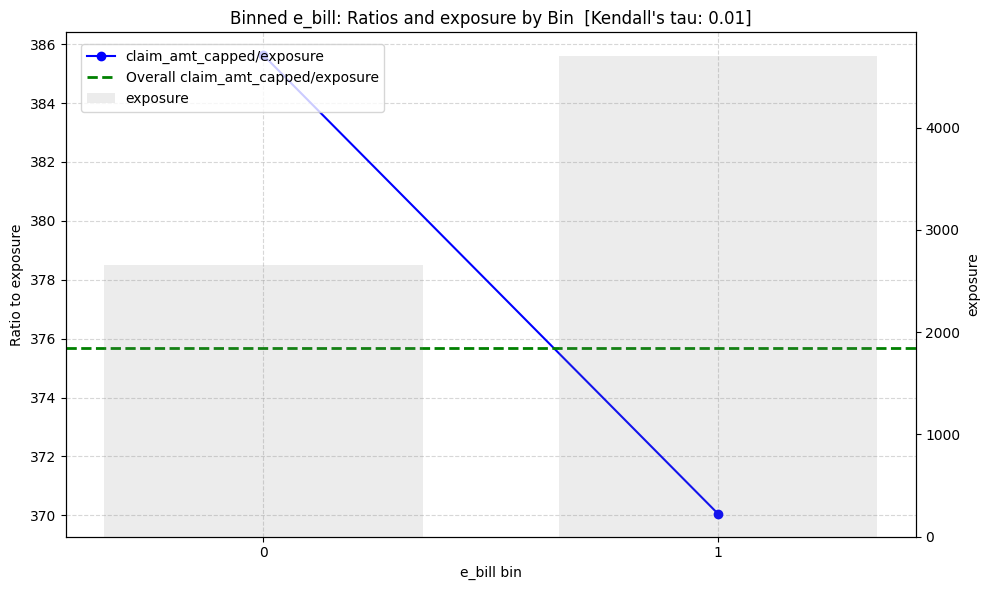


--- Predictiveness Plot for area ---


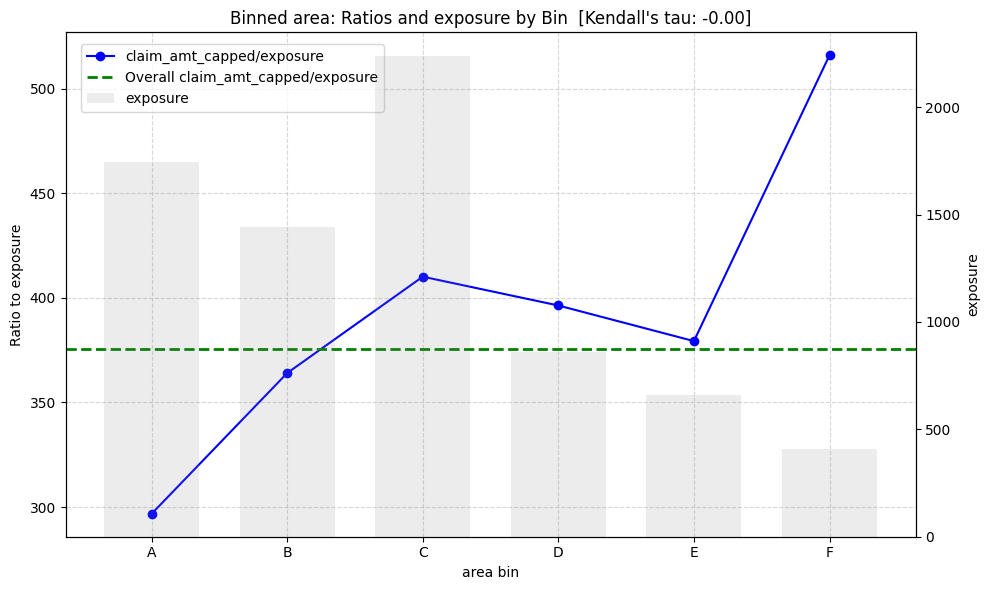


--- Predictiveness Plot for time_of_week_driven ---


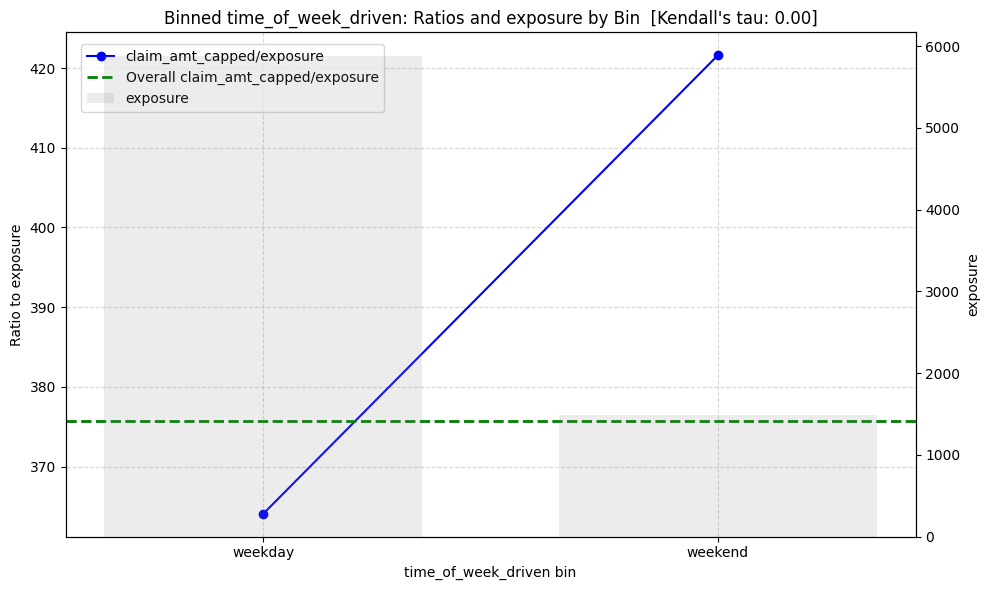


--- Predictiveness Plot for time_driven ---


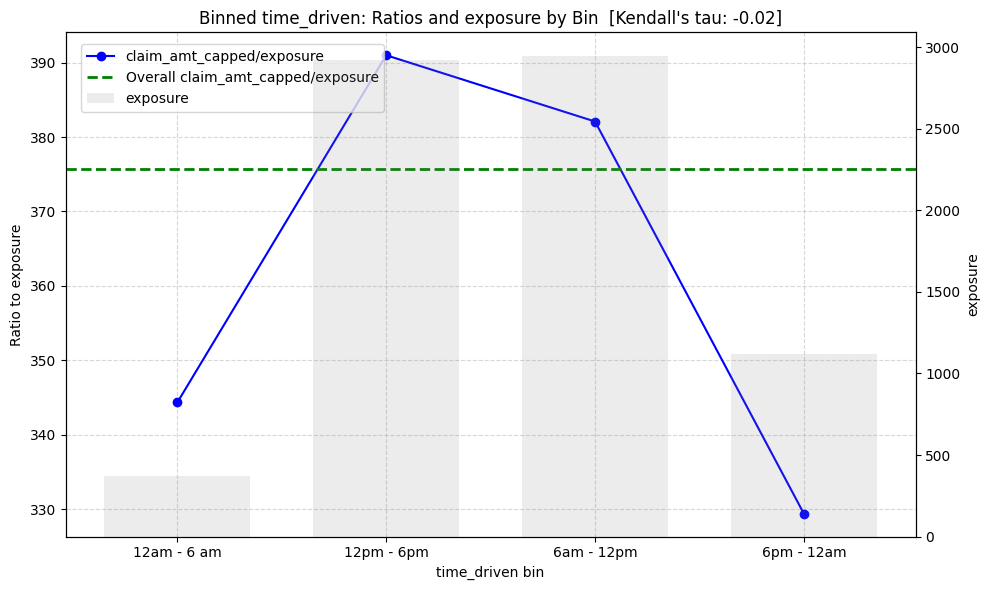


--- Predictiveness Plot for marital_status ---


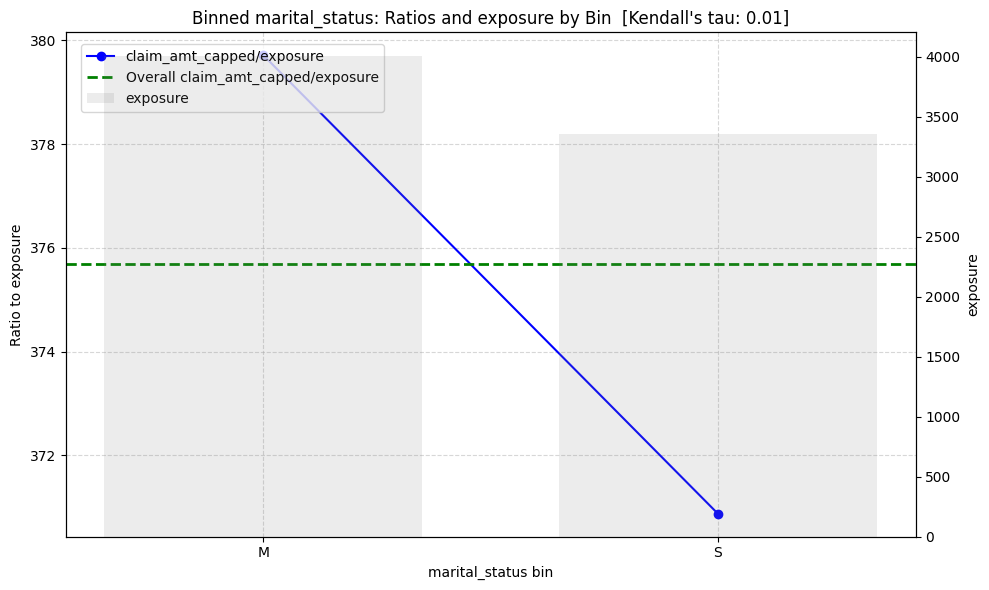


--- Predictiveness Plot for high_education_ind ---


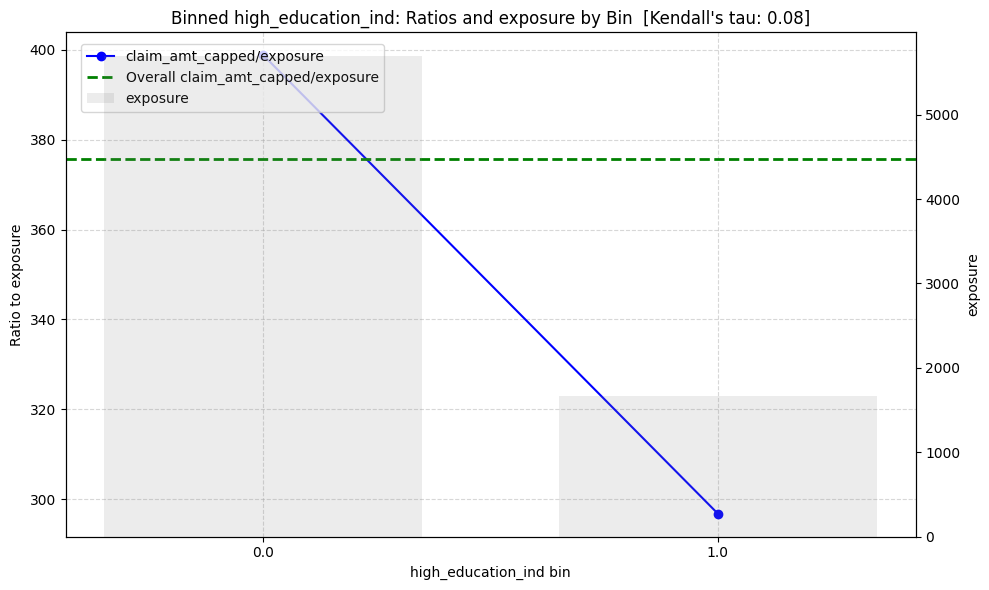


--- Predictiveness Plot for credit_score ---


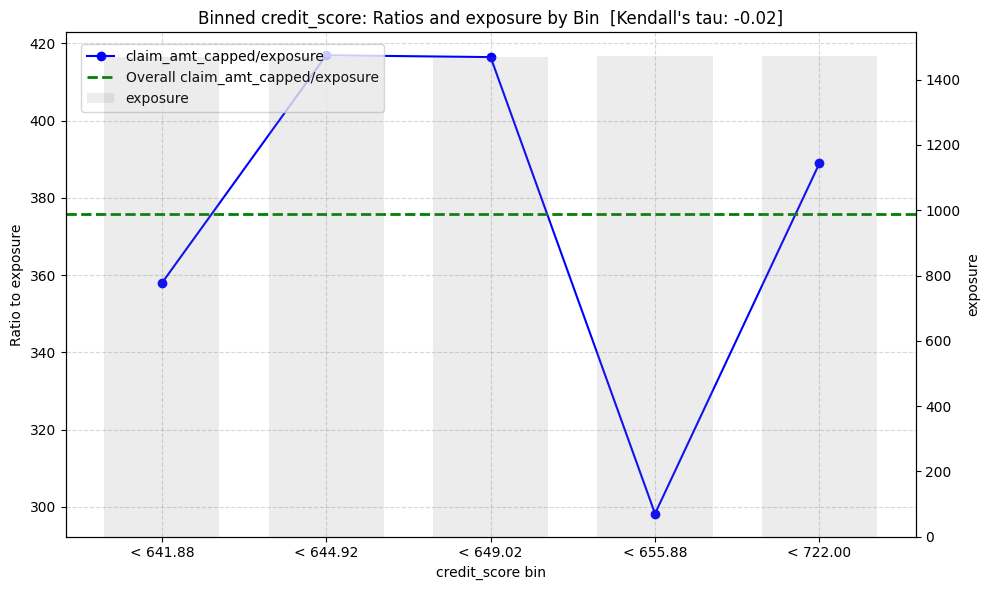


--- Predictiveness Plot for driving_history_score ---


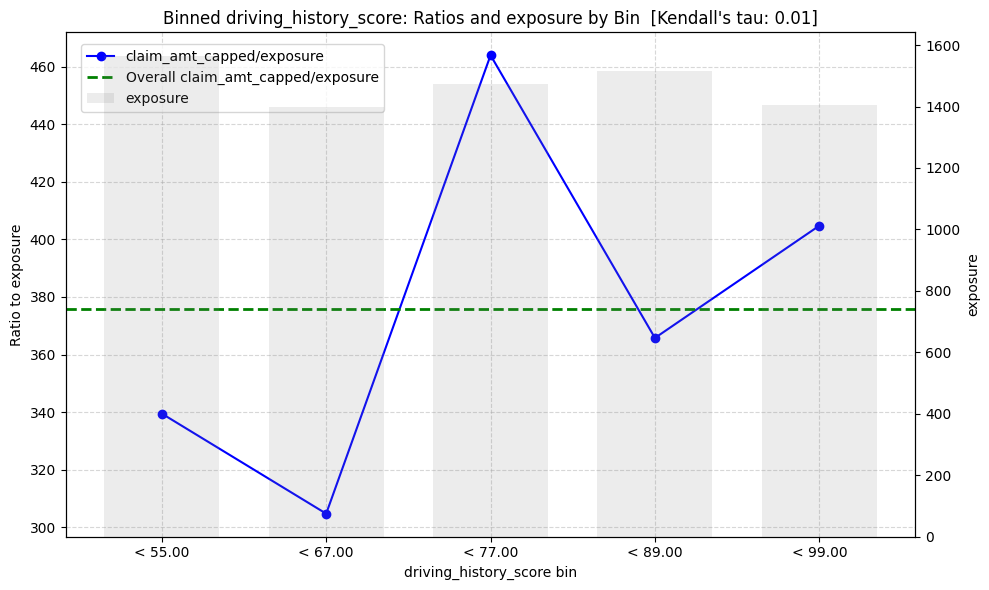

In [15]:
from analysis_tool_chest.data_exploration import PredictivenessCheckList

# Example setup
train_data = model_data.loc[model_data['sample'] == '1|bld']  
exp_var = 'exposure' 
var_1 = 'claim_amt_capped'     
var_2 = None   
nbins = 5         

# Create and run the PredictivenessCheckList
pcl = PredictivenessCheckList(
    data=train_data,
    pred_var_lst=pred_lst,
    exp_var=exp_var,
    var_1=var_1,
    var_2=var_2,     
    nbins=nbins
)

pcl.run_all()
pcl.plot_all()

## Varaible Reduction
### Our case - a baby version

In [16]:
# One-hot encode categorical variables in pred_lst
categorical_cols = [col for col in pred_lst if train_data[col].dtype == 'object' or str(train_data[col].dtype).startswith('category')]
train_data_encoded = pd.get_dummies(train_data, columns=categorical_cols, drop_first=False)

# Update pred_lst to include new dummy variable columns
new_pred_lst = []
for col in pred_lst:
    if col in categorical_cols:
        new_pred_lst.extend([c for c in train_data_encoded.columns if c.startswith(col + '_')])
    else:
        new_pred_lst.append(col)

print('Categorical columns one-hot encoded:', categorical_cols)
print('New predictor list:', new_pred_lst)

Categorical columns one-hot encoded: ['veh_body', 'engine_type', 'veh_color', 'gender', 'area', 'time_of_week_driven', 'time_driven', 'marital_status']
New predictor list: ['veh_value', 'veh_body_COUPE', 'veh_body_HBACK', 'veh_body_HDTOP', 'veh_body_MIBUS', 'veh_body_Other', 'veh_body_PANVN', 'veh_body_SEDAN', 'veh_body_STNWG', 'veh_body_TRUCK', 'veh_body_UTE', 'veh_age', 'engine_type_dissel', 'engine_type_electric', 'engine_type_hybrid', 'engine_type_petrol', 'max_power', 'veh_color_black', 'veh_color_blue', 'veh_color_brown', 'veh_color_gray', 'veh_color_green', 'veh_color_red', 'veh_color_silver', 'veh_color_white', 'veh_color_yellow', 'gender_F', 'gender_M', 'agecat', 'e_bill', 'area_A', 'area_B', 'area_C', 'area_D', 'area_E', 'area_F', 'time_of_week_driven_weekday', 'time_of_week_driven_weekend', 'time_driven_12am - 6 am', 'time_driven_12pm - 6pm', 'time_driven_6am - 12pm', 'time_driven_6pm - 12am', 'marital_status_M', 'marital_status_S', 'high_education_ind', 'credit_score', 'dri

In [17]:
# Create a new DataFrame with 'var_1', all numerical variables in pred_lst and new_pred_lst
# Identify numerical columns in pred_lst and new_pred_lst
num_pred_cols = [col for col in pred_lst if pd.api.types.is_numeric_dtype(train_data[col])]
selected_cols = new_pred_lst + num_pred_cols
train_data_num = train_data_encoded[selected_cols].copy()
print('Columns in new DataFrame:', train_data_num.columns.tolist())
train_data_num.head(5)

Columns in new DataFrame: ['veh_value', 'veh_body_COUPE', 'veh_body_HBACK', 'veh_body_HDTOP', 'veh_body_MIBUS', 'veh_body_Other', 'veh_body_PANVN', 'veh_body_SEDAN', 'veh_body_STNWG', 'veh_body_TRUCK', 'veh_body_UTE', 'veh_age', 'engine_type_dissel', 'engine_type_electric', 'engine_type_hybrid', 'engine_type_petrol', 'max_power', 'veh_color_black', 'veh_color_blue', 'veh_color_brown', 'veh_color_gray', 'veh_color_green', 'veh_color_red', 'veh_color_silver', 'veh_color_white', 'veh_color_yellow', 'gender_F', 'gender_M', 'agecat', 'e_bill', 'area_A', 'area_B', 'area_C', 'area_D', 'area_E', 'area_F', 'time_of_week_driven_weekday', 'time_of_week_driven_weekend', 'time_driven_12am - 6 am', 'time_driven_12pm - 6pm', 'time_driven_6am - 12pm', 'time_driven_6pm - 12am', 'marital_status_M', 'marital_status_S', 'high_education_ind', 'credit_score', 'driving_history_score', 'veh_value', 'veh_age', 'max_power', 'agecat', 'e_bill', 'high_education_ind', 'credit_score', 'driving_history_score']


,veh_value,veh_body_COUPE,veh_body_HBACK,veh_body_HDTOP,veh_body_MIBUS,veh_body_Other,veh_body_PANVN,veh_body_SEDAN,veh_body_STNWG,veh_body_TRUCK,...,credit_score,driving_history_score,veh_value,veh_age,max_power,agecat,e_bill,high_education_ind,credit_score,driving_history_score
0,0.77,False,False,False,False,False,False,True,False,False,...,640.448137,67.0,0.77,4,147,3,1,1.0,640.448137,67.0
2,4.90,False,False,False,False,False,False,False,True,False,...,653.656117,58.0,4.90,1,159,3,1,1.0,653.656117,58.0
3,0.48,False,False,False,False,False,True,False,False,False,...,642.574671,72.0,0.48,4,80,4,1,0.0,642.574671,72.0
4,0.85,False,False,False,False,False,False,True,False,False,...,647.175035,91.0,0.85,4,126,5,0,0.0,647.175035,91.0
6,4.74,False,False,False,False,False,False,False,False,False,...,653.268304,61.0,4.74,1,232,2,1,0.0,653.268304,61.0


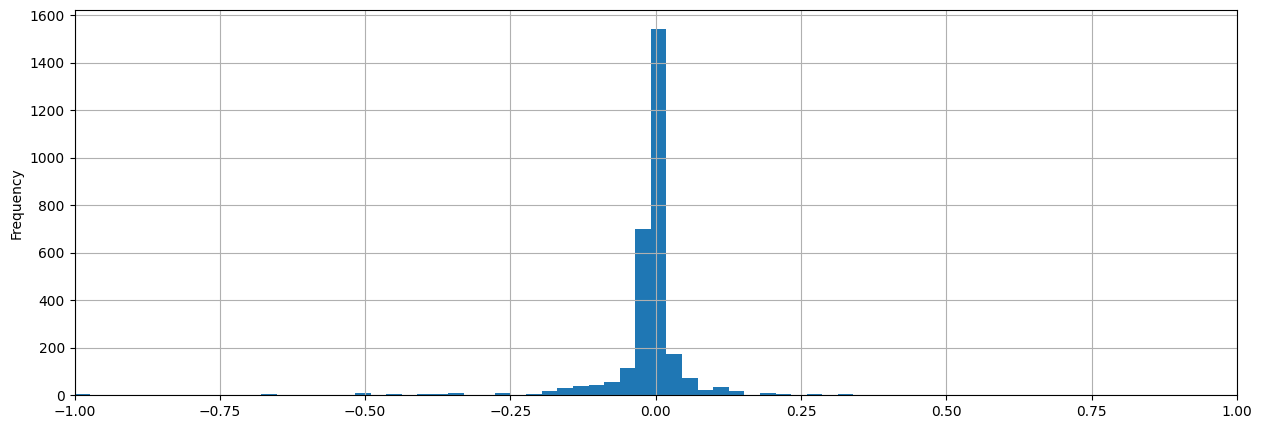

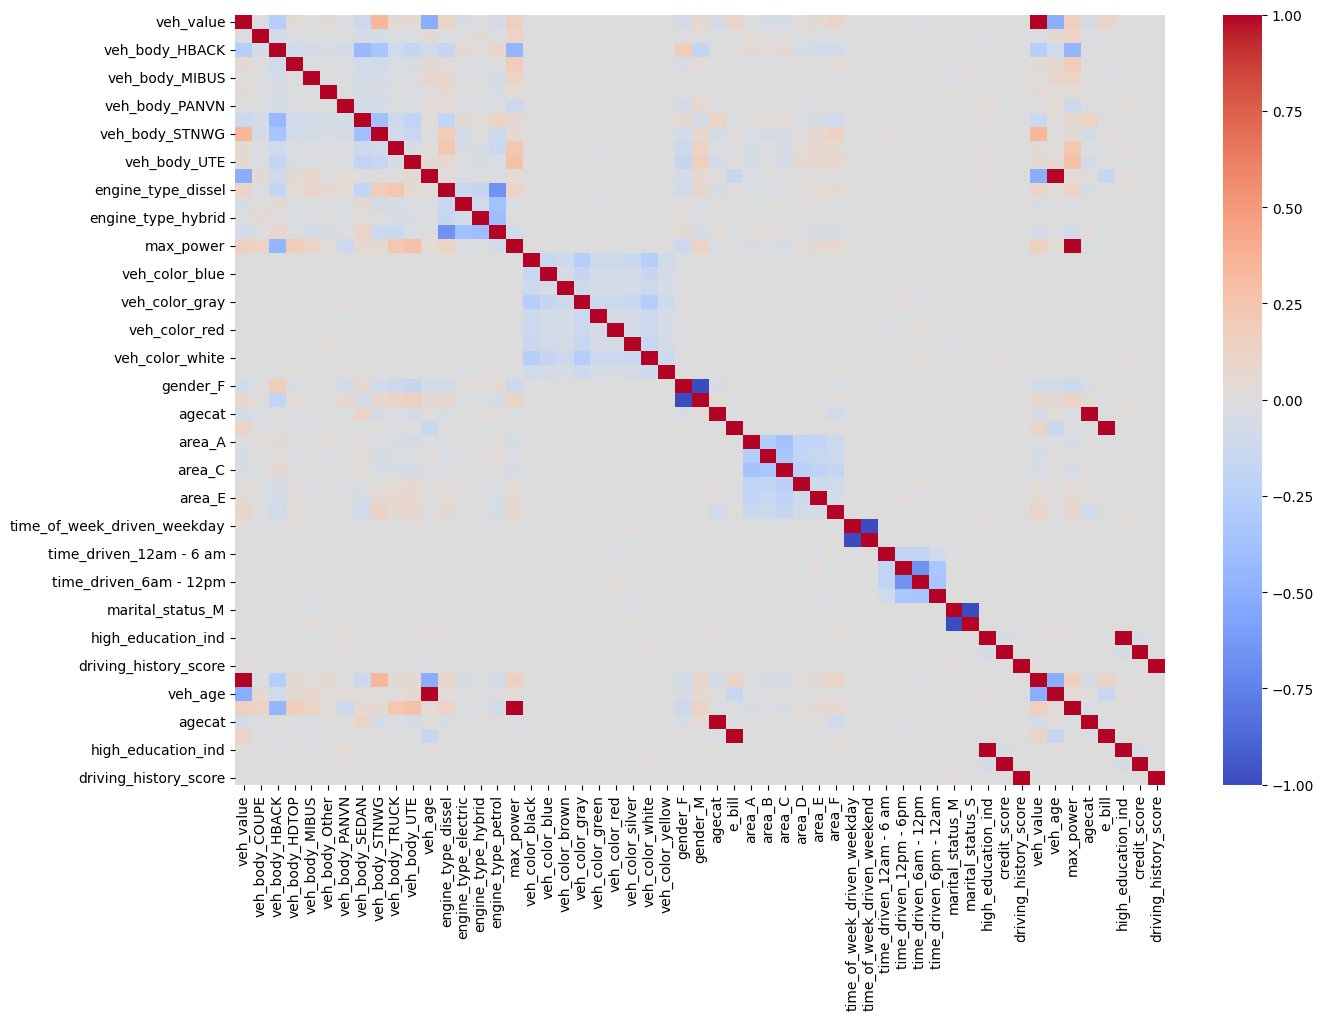

In [18]:
## histogram on the correlation of the predictors
corr_val_df = round(train_data_num.corr(method='kendall'), 2)
corr_val_vec = pd.Series(  [item for sublist in corr_val_df.values.tolist() for item in sublist if item < 1.0] )
rcParams['figure.figsize'] = 15, 4
corr_val_vec.plot.hist( bins = 50, figsize = (15, 5), xlim = (-1, 1), grid = True )
## heatmap on the pairwise correlations among the predictors
import seaborn as sns
plt.subplots( figsize=(15, 10) )
ax = sns.heatmap( corr_val_df, annot = False, cmap = 'coolwarm', vmin = -1, vmax = 1 )
plt.show()

## <span style="color:red"><b><i>Variable Reduction on Real World Scenarios</i></b></span>
In real-wordl application, there are usually hundreds of predictors from different data sources. For instance, in the insurance industry, we usually have the following data sources: 
<br>
1. Internal data: 
    - Telematics: Average speed, Mileage and braking habits, ... 
    - Claim history: Historical 5-yr loss ratio, Historical 3-yr number of physical damage claims, ...
    - Policyholder characters: Gender, Age, Income, Marital status ...
2. Motor vehicle record: Number of major violations, Number of minor violations, ...
3. Geographic data (zip code based): Population density, Average commute time, ...
4. Claimate data:  Distance to nearest water body, Average tempature, ...54. Financial credit data: Credit score, Number of late payments, ...
<br>

#### First round variable reduction via a tree-based algorithm
From my experience, one way to conduct variable reduction with massive data is to utilize a tree-based algorithm for the first round of variable reduction screening.
<br>
1. We start from the most promissing data source. Specifically, we build a tree-based model and delete predictors with the lowest variable importances. Usually, we leave 20-40 predictors on a data source.
2. We build a second tree-based model with the selected predictors from the first data source and all predictors from the second most promissing data source. Then, we remove the predictors with the lowest variable importances from the second data source.
3. We repeat step 2 with the 3rd most promissing data source, the 4th data source, ..., until we screen all data sources. 
<br>
In the end of the first round of variable reduction, we result in 100+ predictors for more precise analysis. - <span style="color:red"><b><i> A flowchat might be helpful to illustrate the first round variable reduction. </i></b></span>





#### Second round variable reduction via VarClusHi - A PCA Embedded Methodology
- VarClusHi Documentations:
    - SAS: https://support.sas.com/documentation/onlinedoc/stat/132/varclus.pdf
    - Python: https://github.com/jingtt/varclushi?tab=readme-ov-file
- <span style="color:red"><b><i>Task 1: </i></b></span> 
    1. <span style="color:red"><b><i>Read and summarize the VarClusHi procedure via markdown.</i></b></span>
    2. <span style="color:red"><b><i>Run the procedure on our data to test its functionality.</i></b></span>

- A VarClusHi Illustration

    | Cluster | Variable              | RS_Own   | RS_NC    | RS_Ratio | Importance | Kendall_tau | 
    |---------|-----------------------|----------|----------|----------|------------|-------------|
    | 0       | fixed acidity         | 0.882210 | 0.277256 | 0.162976 |        0.21|         0.15|
    | 0       | density               | 0.622070 | 0.246194 | 0.501362 |        0.12|         0.05|
    | 0       | pH                    | 0.637076 | 0.194359 | 0.450478 |        0.05|         0.03|
    | 1       | free sulfur dioxide   | 0.777796 | 0.010358 | 0.224530 |        0.32|         0.20|
    | 1       | total sulfur dioxide  | 0.786660 | 0.042294 | 0.222761 |        0.21|         0.15|
    | 1       | residual sugar        | 0.202428 | 0.045424 | 0.835525 |        0.17|         0.12|
    | 2       | sulphates             | 0.685630 | 0.106022 | 0.351653 |        0.07|         0.08|
    | 2       | chlorides             | 0.685630 | 0.048903 | 0.330534 |        0.05|         0.09|
    | 3       | citric acid           | 0.776248 | 0.398208 | 0.371810 |        0.41|         0.25|
    | 3       | volatile acidity      | 0.776248 | 0.040920 | 0.233299 |        0.30|         0.15|
    | 4       | alcohol               | 1.000000 | 0.082055 | 0.000000 |        0.18|         0.12|

## Transformation Check - Additional Task for Linear Models
When building a linear model, we perform additional analysis to floor, cap and transform predictors.
<div style="background-color: #f8f8f8; padding: 10px;">
    <img src="../images/3_transformation_plot.png" alt="Transformation Illustration" style="max-width:50%;">
</div>